# Lektion Cross Selling


## Aufgabenstellung
Sie sollen in einer portugiesichen Privatkundenbank eine Kundenselektion für eine bevorstehende Direktmarketing-Kampagne für eine langfristige Einlage vorbereiten. Ihnen stehen historische Daten aus 17 Kampagenen zwischen Mai 2008 und November 2010 zur Verfügung mit insgesamt rund 41.000 Kontakten. Für jeden Kontakt wurden unterschiedliche Attribute gespeichert und erfasst, ob der Kontakt zu einem Produktabschluss geführt hat oder nicht. Der Datensatz wurde in folgender Forschungsarbeit erhoben und publiziert: S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014).

Erstellen Sie ein Affinitätsmodell.

## Datenbeschreibung


- **bank client data**
    - age (numeric)
    - job : type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")
    - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
    - education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
    - default: has credit in default? (categorical: "no", "yes", "unknown")
    - housing: has housing loan? (categorical: "no", "yes", "unknown")
    - loan: has personal loan? (categorical: "no", "yes", "unknown")
- **related with the last contact of the current campaign**
    - contact: contact communication type (categorical: "cellular", "telephone") 
    - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    - day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
    - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no").
- **other attributes**
    - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    - previous: number of contacts performed before this campaign and for this client (numeric)
    - poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")
- **social and economic context attributes**
    - emp.var.rate: employment variation rate - quarterly indicator (numeric)
    - cons.price.idx: consumer price index - monthly indicator (numeric)     
    - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
    - euribor3m: euribor 3 month rate - daily indicator (numeric)
    - nr.employed: number of employees - quarterly indicator (numeric)
- **Output variable (desired target)**
    - y - has the client subscribed a term deposit? (binary: "yes", "no")

## Struktur
Führen Sie die Datenauswertung in folgenden Schritten aus:
1. [Datenexploration](#Datenexploration)
1. [Datentransformation](#Datentransformation)
1. [Modellierung](#Modellierung)
1. [Auswertung der Modellgüte](#Modellgüte)
1. [Bestimmung der optimalen Werbemenge](#Optimale-Werbemenge)

## Datenexploration

Die Daten sind in der Datei "bank-additional-full.csv" bereitgestellt. <br><br>
a. Importieren Sie benötigte Python Module.<br>
b. Lesen Sie diese ein. Wieviele Zeilen und Spalten hat der Datensatz?<br>
c. Geben Sie einige Zeilen aus.<br>
d. Geben Sie die Datentypen aus. Müssen wir Spalten für die Modellierung transformieren?<br>
e. Generieren Sie deskriptive Statistiken (Mittelwert, Standardabweichung, Min, Max-Werte) für die numerischen Variablen. Explorieren Sie etwaige Ausreißer.<br>
f. Transformieren Sie die Zielvariable in eine Binärkodierung (1/0) und berechnen Sie die Pearson Korrelationskoeffizienten aller numerischen Variablen mit der Zielvariable. Gibt es Auffälligkeiten?<br>
g. Generieren Sie deskriptive Statistiken für die kategorischen Variablen (Anzahl Merkmalsausprägungen, Anzahl Datensätze pro Merkmalsausprägung). Müssen Merkmalsausprägungen zusammengeführt werden?<br>
h. Analysieren Sie die Verteilung der Zielvariable. Handelt es sich um eine balancierten Datensatz?

In [1]:
# a. Importieren Sie benötigte Python Module.
# Import von wesentlichen Modulen und Einstellungen
# Gerne können Sie Module ergänzen oder entfernen
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)

In [2]:
# b. Lesen Sie diese ein. Wieviele Zeilen und Spalten hat der Datensatz?
bank = pd.read_csv("bank-additional-full.csv", sep=";")
bank.shape

(41188, 21)

In [3]:
# c. Geben Sie einige Zeilen aus.
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# d. Geben Sie die Datentypen aus. Müssen wir Spalten für die Modellierung transformieren?
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# e. Generieren Sie deskriptive Statistiken (Mittelwert, Standardabweichung, Min, Max-Werte) für die numerischen Variablen. Explorieren Sie etwaige Ausreißer.
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


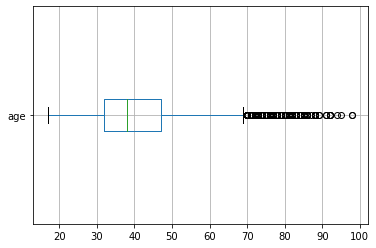

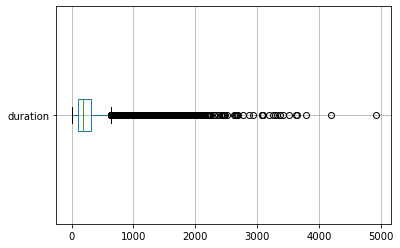

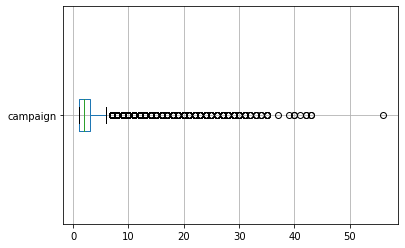

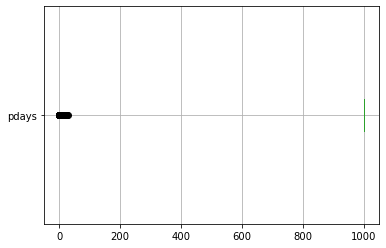

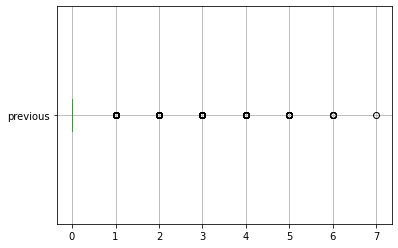

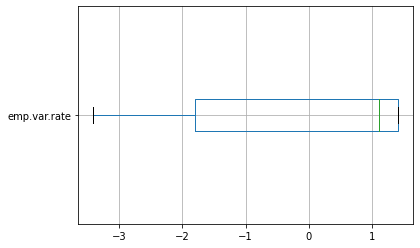

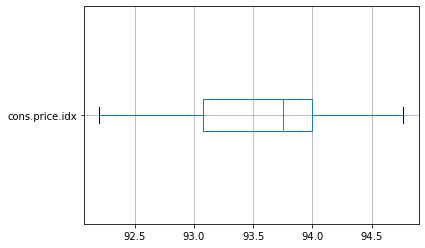

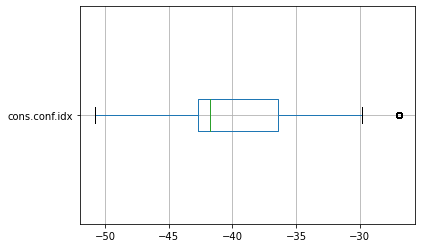

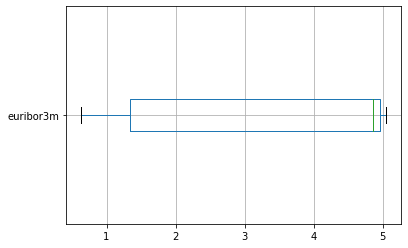

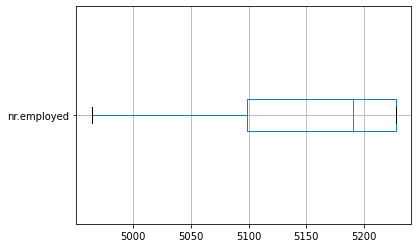

In [6]:
for column in bank.select_dtypes(include=np.number):
    plt.figure()
    bank.boxplot([column], vert=False)


<AxesSubplot:>

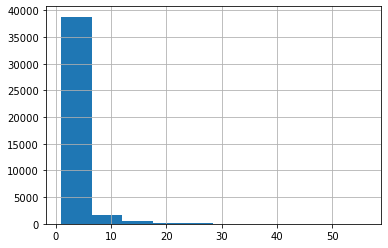

In [7]:
# Exploration Campaign
bank.campaign.hist()

<AxesSubplot:>

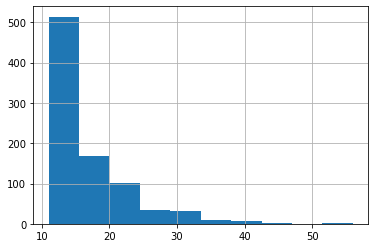

In [8]:
bank[bank.campaign>10].campaign.hist()

In [9]:
bank[bank.campaign>10].sort_values('campaign', ascending=False).head(20)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4107,32,admin.,married,university.degree,unknown,unknown,unknown,telephone,may,mon,261,56,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
18728,54,admin.,married,university.degree,unknown,yes,no,cellular,jul,thu,65,43,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
13447,32,technician,single,university.degree,no,yes,yes,telephone,jul,wed,16,43,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
4168,29,technician,married,professional.course,no,yes,no,telephone,may,mon,124,42,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
5304,44,retired,married,basic.9y,no,yes,no,telephone,may,fri,147,42,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11033,38,blue-collar,married,basic.4y,no,yes,no,telephone,jun,wed,25,41,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
18754,36,admin.,single,university.degree,no,no,no,cellular,jul,thu,18,40,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
11769,56,self-employed,married,professional.course,no,no,yes,telephone,jun,fri,13,40,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4114,52,entrepreneur,married,university.degree,no,no,no,telephone,may,mon,44,39,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
11593,43,technician,married,high.school,no,yes,no,telephone,jun,fri,17,37,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no


<AxesSubplot:>

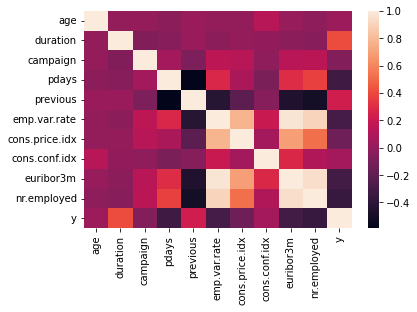

In [11]:
# f. Transformieren Sie die Zielvariable in eine Binärkodierung (1/0) und berechnen Sie die Pearson Korrelationskoeffizienten aller numerischen Variablen mit der Zielvariable. Gibt es Auffälligkeiten?
bank["y"]= bank.y.replace({"no":0, "yes":1})
corrs = bank.select_dtypes(include=np.number).corr()
sns.heatmap(corrs)

In [12]:
corrs['y'].sort_values(ascending=False)

y                 1.000000
duration          0.405274
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
campaign         -0.066357
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y, dtype: float64

In [13]:
# g. Generieren Sie deskriptive Statistiken für die kategorischen Variablen (Anzahl Merkmalsausprägungen, Anzahl Datensätze pro Merkmalsausprägung). Müssen Merkmalsausprägungen zusammengeführt werden?
bank.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


In [14]:
for column in bank.select_dtypes(exclude=np.number):
    print(column)
    print(bank.groupby('y')[column].value_counts(dropna=False))
    print()

job
y  job          
0  admin.           9070
   blue-collar      8616
   technician       6013
   services         3646
   management       2596
   entrepreneur     1332
   retired          1286
   self-employed    1272
   housemaid         954
   unemployed        870
   student           600
   unknown           293
1  admin.           1352
   technician        730
   blue-collar       638
   retired           434
   management        328
   services          323
   student           275
   self-employed     149
   unemployed        144
   entrepreneur      124
   housemaid         106
   unknown            37
Name: job, dtype: int64

marital
y  marital 
0  married     22396
   single       9948
   divorced     4136
   unknown        68
1  married      2532
   single       1620
   divorced      476
   unknown        12
Name: marital, dtype: int64

education
y  education          
0  university.degree      10498
   high.school             8484
   basic.9y                5572
   profe

In [15]:
# h. Analysieren Sie die Verteilung der Zielvariable. Handelt es sich um eine balancierten Datensatz?
bank.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

## Datentransformation

a. Entfernen Sie falls notwendig Datensätze.<br>
b. Entfernen Sie falls notwendig Spalten.<br>
c. Splitten Sie den Datensatz in Train (80%) und Test Set (20%). Achten Sie darauf, dass die Zielvariable jeweils gleich verteilt ist.<br>
d. Muss eine Leerwertauffüllung durchgeführt werden?<br>
e. Führen Sie eine Standardisierung der numerischen Variablen und ein One-Hot-Encoding der kategorischen Variablen durch.<br>

In [16]:
# a. Entfernen Sie falls notwendig Datensätze.

# Datensätze mit default="yes" sollten entfernt werden da sie sehr selten auftreten und weil keine Abschlüsse auftreten.
bank = bank[bank.default!="yes"]

In [17]:
# b. Entfernen Sie falls notwendig Spalten.

# Die Spalte duration sollte entfernt werden weil hier eine rückwärtsgerichtete Kausalität auftritt.
bank.drop(columns=["duration"], inplace=True)

In [18]:
# c. Splitten Sie den Datensatz in Train (80%) und Test Set (20%). Achten Sie darauf, dass die Zielvariable jeweils gleich verteilt ist.
X_train, X_test, y_train, y_test = train_test_split(bank.drop("y", axis=1),bank["y"],test_size=0.2, random_state=99, stratify=bank["y"])

In [19]:
# d. Muss eine Leerwertauffüllung durchgeführt werden?
print("Anzahl Leerwerte: {}".format(bank.isna().sum().sum()))

Anzahl Leerwerte: 0


In [20]:
# e. Führen Sie eine Standardisierung der numerischen Variablen und ein One-Hot-Encoding der kategorischen Variablen durch.
numeric_features=X_train.select_dtypes(include=np.number).columns
categorical_features=X_train.select_dtypes(exclude=np.number).columns

numeric_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()

preprocessor=ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)       
    ]
)

## Modellierung

a. Nutzen Sie den [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) mit den Standardeinstellungen. Nehmen Sie lediglich eine Einstellung vor, damit die Unbalanciertheit ausgeglichen wird. Nutzen Sie [get_params](), um die Parametereinstellungen auszugeben.
b. Bestimmen Sie die [AUC: Area Under the Receiver Operating Characteristic Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) des Modells für den **Trainingsdatensatz**. <br>
c. Nutzen Sie Kreuzvalidierung ([scikit-learn cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)) auf dem **Trainingsdatensatz**, um die AUC des berechneten Modells für unbekannte Daten zu bestimmen. Liegt Überanpassung (Overfitting) vor?<br>
d. Führen Sie für den RandomForestClassifier eine Hyperparameteroptimierung durch. Fokussieren Sie sich zunächst auf die Parameter n_estimators, max_features und max_depth. Nutzen Sie hierfür entweder [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) oder [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Geben Sie die Modellparameter sowie den AUC-Wert des besten Modells aus. 
e. Berechnen Sie den AUC-Wert des optimierten Modells für den **Trainingsdatensatz**. Konnten Sie das Problem der Überanpassung reduzieren?

In [21]:
%%time
# a. Nutzen Sie den [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) mit den Standardeinstellungen. Nehmen Sie lediglich eine Einstellung vor, damit die Unbalanciertheit ausgeglichen wird. Nutzen Sie [get_params](), um die Parametereinstellungen auszugeben.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(class_weight="balanced", random_state=99))]
)
clf.fit(X_train, y_train)
clf.get_params()

CPU times: total: 8.55 s
Wall time: 9.64 s


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
         dtype='object')),
                                   ('cat', OneHotEncoder(),
                                    Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
          'month', 'day_of_week', 'poutcome'],
         dtype='object'))])),
  ('classifier',
   RandomForestClassifier(class_weight='balanced', random_state=99))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object')),
                                 ('cat', OneHotEncoder(),
        

In [22]:
# b. Bestimmen Sie die [AUC: Area Under the Receiver Operating Characteristic Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) des Modells für den **Trainingsdatensatz**.
y_pred=clf.predict(X_train)
print("Accuracy: %.3f" % clf.score(X_train, y_train))
print("AUC: %.3f" % roc_auc_score(y_train, y_pred))

Accuracy: 0.994
AUC: 0.995


In [23]:
%%time
# c. Nutzen Sie Kreuzvalidierung (scikit-learn cross_val_score) auf dem Trainingsdatensatz, um die AUC für unbekannte Daten zu bestimmen. Liegt Überanpassung (Overfitting) vor?
scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='roc_auc')
print("individual scores: {}".format(scores))
print("mean score: {}".format(np.mean(scores)))

individual scores: [0.78226544 0.76161667 0.7724204  0.75833349]
mean score: 0.7686590008008549
CPU times: total: 27 s
Wall time: 29.1 s


In [24]:
%%time
#d. Führen Sie für den RandomForestClassifier eine Hyperparameteroptimierung durch. Fokussieren Sie sich zunächst auf die Parameter n_estimators, max_features und max_depth. Nutzen Sie hierfür entweder [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) oder [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(4, 18, num = 7)]
max_depth.append(None)

# create random grid
random_grid = {
 'classifier__n_estimators': n_estimators,
 'classifier__max_features': max_features,
 'classifier__max_depth': max_depth
 }

# define evaluation procedure
cv = StratifiedKFold(n_splits=3)

# define grid search
rfc_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_jobs=-1, cv=cv, scoring='roc_auc', n_iter=32)
search = rfc_random.fit(X_train, y_train)

# result
print("Best AUC: {}".format(rfc_random.best_score_))
print("Best params: {}".format(rfc_random.best_params_))

Best AUC: 0.7967035044197802
Best params: {'classifier__n_estimators': 183, 'classifier__max_features': 'auto', 'classifier__max_depth': 8}
CPU times: total: 13.9 s
Wall time: 4min 3s


In [25]:
# e. Berechnen Sie den AUC-Wert des optimierten Modells für den **Trainingsdatensatz**. Konnten Sie das Problem der Überanpassung reduzieren?
y_pred_random=rfc_random.predict(X_train)
print("Accuracy Optimized: %.3f" % clf.score(X_train, y_train))
print("AUC Optimized: %.3f" % roc_auc_score(y_train, y_pred))

Accuracy Optimized: 0.994
AUC Optimized: 0.995


## Modellgüte

a. Wenden Sie sich nun dem Testdatensatz zu. Berechnen Sie die prognostizierten Klassenzugehörigkeiten und stellen Sie die [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) dar. Geben Sie auch den AUC-Wert an.<br>
b. Nutzen Sie [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), um Precision, Recall und F1-Score zu berechnen.<br>
c. Nutzen Sie [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), um den Verlauf von Precision und Recall in Abhängigkeit des Klassifikationsschwellenwertes darzustellen.<br>
d. Was wäre für den beschriebenen Anwendungsfall ein geeigneter Klassifikationsschwellwert? Berechnen Sie die [F1-Scores](https://en.wikipedia.org/wiki/F-score). Bei welchem Klassifikationsschwellenwert nimmt der F1-Score einen Maximalwert an?<br>
e. Nehmen Sie den eben berechneten Maximalwert als Klassifikationsschwellwert und berechnen Sie den [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) neu.


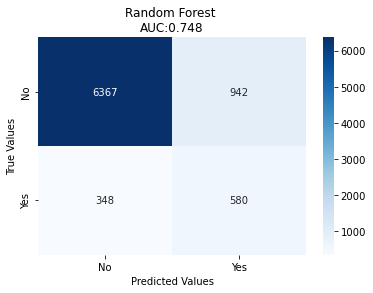

In [26]:
# a. Wenden Sie sich nun dem Testdatensatz zu. Berechnen Sie die prognostizierten Klassenzugehörigkeiten und stellen Sie die [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) dar. Geben Sie auch den AUC-Wert an.
y_pred_test=rfc_random.predict(X_test)
cm=confusion_matrix(y_test, y_pred_test) 
cm_df = pd.DataFrame(cm,
                     index = ['No', 'Yes'], 
                     columns = ['No', 'Yes'])
#plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
plt.title('Random Forest \nAUC:{0:.3f}'.format(roc_auc_score(y_test, y_pred_test)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [27]:
# b. Nutzen Sie [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), um Precision, Recall und F1-Score zu berechnen.
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred_test,target_names=target_names))

              precision    recall  f1-score   support

          No       0.95      0.87      0.91      7309
         Yes       0.38      0.62      0.47       928

    accuracy                           0.84      8237
   macro avg       0.66      0.75      0.69      8237
weighted avg       0.88      0.84      0.86      8237



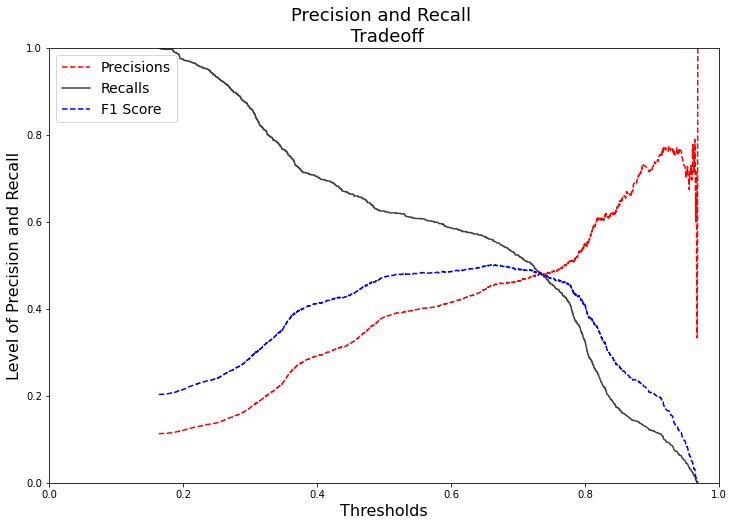

In [28]:
# c. Nutzen Sie [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), um den Verlauf von Precision und Recall in Abhängigkeit des Klassifikationsschwellenwertes darzustellen.
y_pred_testprob=rfc_random.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_testprob)
f1_scores = 2*recalls*precisions/(recalls+precisions)

def precision_recall_curve(precisions, recalls, thresholds, f1_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.plot(thresholds, f1_scores[:-1], "b--", label="F1 Score")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0, 1])
 
precision_recall_curve(precisions, recalls, thresholds, f1_scores)
plt.show()

In [29]:
# d. Was wäre für den beschriebenen Anwendungsfall ein geeigneter Klassifikationsschwellwert? Berechnen Sie die [F1-Scores](https://en.wikipedia.org/wiki/F-score). Bei welchem Klassifikationsschwellenwert nimmt der F1-Score einen Maximalwert an?
best_threshold = thresholds[np.argmax(f1_scores)]
print("best threshold: {:.3f}".format(best_threshold))

best threshold: 0.662


In [30]:
# e. Nehmen Sie den eben berechneten Maximalwert als Klassifikationsschwellwert und berechnen Sie den [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) neu.
y_pred_thres = (y_pred_testprob >= best_threshold).astype(bool)
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred_thres,target_names=target_names))

              precision    recall  f1-score   support

          No       0.94      0.91      0.93      7309
         Yes       0.45      0.56      0.50       928

    accuracy                           0.87      8237
   macro avg       0.70      0.74      0.71      8237
weighted avg       0.89      0.87      0.88      8237



## Optimale Werbemenge

a. Analysieren sie zunächst die Variablenwichtigkeiten des optimierten Modells. Stellen Sie die 10 wichtigsten Variablen grafisch dar.<br>
b. Welche Ratschläge würden Sie der Bank auf Basis der Variablenwichtigkeiten geben?<br>
c. Nehmen Sie vereinfachend an, dass die Kunden des Testdatensatzes noch keiner Werbemaßnahme zugeführt wurden und Sie entprechend die Kundenreaktion nicht kennen. Erstellen Sie aus dem Testdatensatz einen fiktiven Vorhersagedatensatz ("prediction set"), in dem Sie den Testdatensatz kopieren und die externen Einflussfaktoren fixieren: Ersetzen Sie folgende Spalten mit dem jeweiligen Median: "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed". Bestimmen Sie für den so konstruierten Vorhersagedatensatz unter folgenden Annahmen die optimale Werbemenge: Fixkosten der Werbemaßname: 2000€, variable Kosten der Werbemaßnahme pro Kunde: 30€, Deckungsbeitrag pro erfolgreichem Abschluss: 100 €. Nutzen Sie dabei die Klassenwahrscheinlichkeit [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) als Kaufwahrscheinlichkeit. Stellen Sie zudem den Zusammenhang aus Werbemenge und Kampagnenertrag grafisch dar.  

<AxesSubplot:>

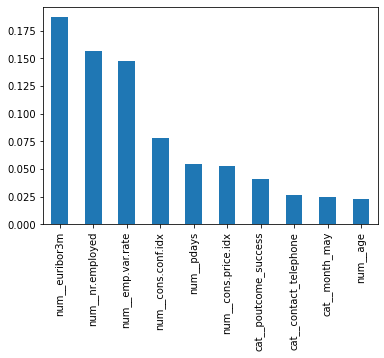

In [31]:
# a. Analysieren sie zunächst die Variablenwichtigkeiten des optimierten Modells. Stellen Sie die 10 wichtigsten Variablen grafisch dar.
importances = rfc_random.best_estimator_.steps[1][1].feature_importances_
# Achtung: dieser Schritt benötigt eine aktuelle scikit-learn version!
forest_importances = pd.Series(importances, index=clf.steps[0][1].get_feature_names_out())
forest_importances.sort_values(ascending=False)[0:10].plot(kind='bar')

In [32]:
# correlation analysis to guess influence direction
# get scales and encoded data set as data frame
X_train_prepared = preprocessor.fit_transform(X_train)
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=preprocessor.get_feature_names_out())
X_train_prepared_df["y"]=y_train

# select important variables and calculate correlation coefficients
preds=list(forest_importances.sort_values(ascending=False).index[0:10])
preds.append('y')
preds_corr=X_train_prepared_df[preds].corr()
preds_corr["y"].sort_values(ascending=False)

y                         1.000000
num__age                  0.007200
num__nr.employed          0.004815
num__pdays                0.001842
num__euribor3m            0.001833
cat__contact_telephone    0.001085
num__emp.var.rate         0.001050
num__cons.conf.idx       -0.000100
cat__month_may           -0.001916
num__cons.price.idx      -0.002971
cat__poutcome_success    -0.003578
Name: y, dtype: float64

b. Welche Ratschläge würden Sie der Bank auf Basis der Variablenwichtigkeiten geben?<br>
- Die Makroökonomischen Faktoren (Leitzins, Arbeitslosenrate, Vertrauensindex) spielen für den Kampagnenerfolg eine entscheidende Rolle und sollten bei der Kampagnenterminierung berücksichtigt werden.
- pdays: Steht die Bank mit den Kunden im regelmäßigen Kontakt ist die Abschlusswahrscheinlichkeit höher. Es sollte intensiv in eine regelmäßige Kundenbindung investiert werden.
- num_age: Ältere Kunden haben eine höhere Abschlusswahrscheinlichkeit.
- poutcome_success: Haben Kunden in Vorkampagnen bereits abgeschlossen ist die Abschlusswahrscheinlichkeit geringer.
- contact_telephone: Das Festnetztelefon ist der erfolgreichere Abschlusskanal.
- month_may: Im Monat Mai machen Kunden tendenziell weniger Abschlüsse.

c. Nehmen Sie vereinfachend an, dass die Kunden des Testdatensatzes noch keiner Werbemaßnahme zugeführt wurden und Sie entprechend die Kundenreaktion nicht kennen. Erstellen Sie aus dem Testdatensatz einen fiktiven Vorhersagedatensatz ("prediction set"), in dem Sie den Testdatensatz kopieren und die externen Einflussfaktoren fixieren: Ersetzen Sie folgende Spalten mit dem jeweiligen Median: "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed". Bestimmen Sie für den so konstruierten Vorhersagedatensatz unter folgenden Annahmen die optimale Werbemenge: Fixkosten der Werbemaßname: 2000€, variable Kosten der Werbemaßnahme pro Kunde: 30€, Deckungsbeitrag pro erfolgreichem Abschluss: 100 €. Nutzen Sie dabei die Klassenwahrscheinlichkeit [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) als Kaufwahrscheinlichkeit. Stellen Sie zudem den Zusammenhang aus Werbemenge und Kampagnenertrag grafisch dar.

Text(0.5, 1.0, 'Ertragskurve (Maximalertrag 18400€ bei Werbemenge 5234)')

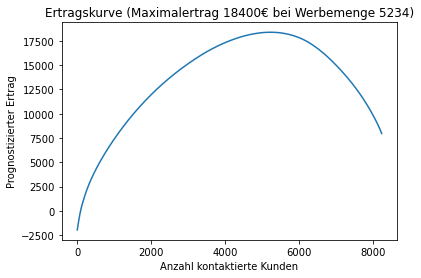

In [35]:
# create prediction data set
X_prediction = X_test.copy()
y_prediction = y_test.copy()

# fixate external variables to median
external_variables = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
for external in external_variables:
    external_median = X_prediction[external].median()
    X_prediction[external] = external_median
    
# calculate and sort probailities
y_predprob=rfc_random.predict_proba(X_prediction)[:,1].tolist()
y_predprob.sort(reverse=True)

# Calculate campaign result in relation to campaign size
cost = y_predprob[0]*100-30-2000
costlist=[cost]
i=1
while i<len(y_predprob):
    cost = costlist[i-1]+y_predprob[i]*100-30
    costlist.append(cost)
    i+=1
    
# Plot result
plt.plot(costlist)
plt.xlabel("Anzahl kontaktierte Kunden")
plt.ylabel("Prognostizierter Ertrag")
plt.title("Ertragskurve (Maximalertrag {0:.0f}€ bei Werbemenge {1})".format(max(costlist),np.argmax(costlist)+1))

